In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyasdf
import obspy
from obspy.geodetics.base import gps2dist_azimuth,kilometer2degrees
from obspy.taup import TauPyModel

%matplotlib inline

model = TauPyModel(model="ak135")
from obspy.signal.util import _npts2nfft

In [15]:
def process_single_data_trace(net_sta,asdf_file):
    data=pyasdf.ASDFDataSet(asdf_file,mode="r")
    
    event = data.events[0]
    origin = event.preferred_origin() or event.origins[0]
    event_time = origin.time
    event_latitude = origin.latitude
    event_longitude = origin.longitude
    event_depth=origin.depth
    
    st=data.waveforms[net_sta].raw.copy()
    
    st.trim(event_time,event_time+1800)
    
    st.detrend("demean")
    st.detrend("linear")
    st.taper(max_percentage=0.05,type="hann")
    
    inv=data.waveforms[net_sta].StationXML
    
    max_period=100
    min_period=10
    f2 = 1.0 / max_period
    f3 = 1.0 / min_period
    f1 = 0.5 * f2
    f4 = 2.0 * f3
    pre_filt = (f1, f2, f3, f4)
    
    st.remove_response(output="DISP", pre_filt=pre_filt, zero_mean=False,
                               taper=False, inventory=inv, water_level=None)
    
    st.interpolate(sampling_rate=10)
    
    station_latitude = inv[0][0].latitude
    station_longitude = inv[0][0].longitude
    gcarc_m, baz, _ = gps2dist_azimuth(station_latitude, station_longitude,
                                             event_latitude, event_longitude)
    baz = np.mod(baz, 360)
    st.rotate(method="NE->RT", back_azimuth=baz)
    
    st.filter("bandpass",freqmin=1/100,freqmax=1/10,corners=2,zerophase=True)
    
#     to_plot=st.slice(event_time+kilometer2degrees(gcarc_m/1000)*18+20,event_time+kilometer2degrees(gcarc_m/1000)*18+140)
#     to_plot=st.slice(event_time,event_time+600)
    
    to_plot=st
    return to_plot,kilometer2degrees(gcarc_m/1000)

In [3]:
asdf_file="/Users/ziyixi/work/Japan_Slab_code/data/asdf_files/compare_data_processing/201105101526A.data.h5"

In [4]:
net_sta_list=["BO.WJM","BO.SRN","BO.KNM","BO.TTO","BO.NAA","BO.FUJ","BO.KNY"]

In [5]:
def sync_remove_response(pre_filt, st):
    """
    mimic obspy.remove_response, but only do the frequency taper
    """
    obspy.core.util.misc.limit_numpy_fft_cache()
    for trace in st:
        data = trace.data.astype(np.float64)
        npts = len(data)
        nfft = _npts2nfft(npts)
        data = np.fft.rfft(data, n=nfft)
        t_samp = trace.stats.delta
        fy = 1 / (t_samp * 2.0)
        freqs = np.linspace(0, fy, nfft // 2 + 1).astype(np.float64)
        freq_domain_taper = obspy.signal.invsim.cosine_sac_taper(
            freqs, flimit=pre_filt)
        data *= freq_domain_taper
        data = np.fft.irfft(data)[0:npts]
        trace.data = data

    return st

The time difference is due to the location mismatch and the event time difference, so we should cut the synthetics using the data time.

In [14]:
def process_single_data_trace_synthetic(net_sta,asdf_file):
    data=pyasdf.ASDFDataSet(asdf_file,mode="r")
    
    event = data.events[0]
    origin = event.preferred_origin() or event.origins[0]
    event_time = origin.time
    event_latitude = origin.latitude
    event_longitude = origin.longitude
    event_depth=origin.depth
    
    st=data.waveforms[net_sta].synthetic.copy()
    
    st.trim(event_time,event_time+1800)
    
    st.detrend("demean")
    st.detrend("linear")
    st.taper(max_percentage=0.05,type="hann")
    
    inv=data.waveforms[net_sta].StationXML
    
    max_period=100
    min_period=10
    f2 = 1.0 / max_period
    f3 = 1.0 / min_period
    f1 = 0.5 * f2
    f4 = 2.0 * f3
    pre_filt = (f1, f2, f3, f4)
    
#     st.remove_response(output="DISP", pre_filt=pre_filt, zero_mean=False,
#                                taper=False, inventory=inv, water_level=None)
    st=sync_remove_response(pre_filt, st)
    
    st.interpolate(sampling_rate=10)
    
    station_latitude = inv[0][0].latitude
    station_longitude = inv[0][0].longitude
    gcarc_m, baz, _ = gps2dist_azimuth(station_latitude, station_longitude,
                                             event_latitude, event_longitude)
    baz = np.mod(baz, 360)
    st.rotate(method="NE->RT", back_azimuth=baz)
    
    st.filter("bandpass",freqmin=1/100,freqmax=1/10,corners=2,zerophase=True)
    
    to_plot=st.slice(event_time+kilometer2degrees(gcarc_m/1000)*18+20,event_time+kilometer2degrees(gcarc_m/1000)*18+140)
#     to_plot=st.slice(event_time,event_time+600)
    
#     to_plot=st
    return to_plot,kilometer2degrees(gcarc_m/1000)

In [11]:
asdf_file_synthetic="/Users/ziyixi/work/Japan_Slab_code/data/asdf_files/compare_tao_cmt/FWEA18_nosmooth_201105101526A_newcmt.h5"

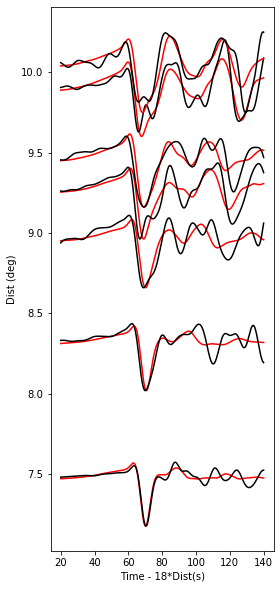

In [16]:
plt.figure(figsize=(4,10))
for net_sta in net_sta_list:
    to_plot,gcarc=process_single_data_trace_synthetic(net_sta,asdf_file_synthetic)
    to_plot_data,_=process_single_data_trace(net_sta,asdf_file)
    to_plot_data.trim(to_plot[0].stats.starttime,to_plot[0].stats.endtime)
    to_plot=to_plot[2]
    to_plot_data=to_plot_data[0]
    to_plot.normalize()
    to_plot_data.normalize()
    x=np.linspace(20,to_plot.stats.endtime-to_plot.stats.starttime+20,to_plot.stats.npts)
    y=to_plot.data*(-0.3)+gcarc
    x_data=np.linspace(20,to_plot_data.stats.endtime-to_plot_data.stats.starttime+20,to_plot_data.stats.npts)
    y_data=to_plot_data.data*(-0.3)+gcarc
    plt.plot(x,y,color="r")
    plt.plot(x_data,y_data,color="k")
    plt.xlabel("Time - 18*Dist(s)")
    plt.ylabel("Dist (deg)")

In [42]:
asdf_file_synthetic="/Users/ziyixi/work/Japan_Slab_code/data/asdf_files/compare_tao_cmt/EARA2014_nosmooth_crust2.0_201105101526A_newcmt.h5"

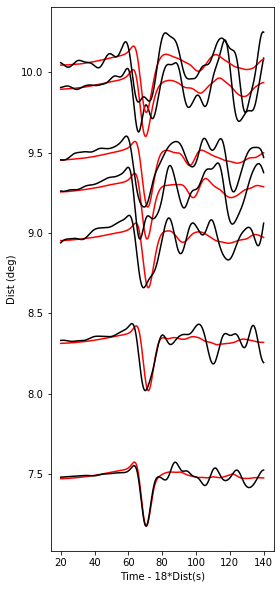

In [34]:
plt.figure(figsize=(4,10))
for net_sta in net_sta_list:
    to_plot,gcarc=process_single_data_trace_synthetic(net_sta,asdf_file_synthetic)
    to_plot_data,_=process_single_data_trace(net_sta,asdf_file)
    to_plot_data.trim(to_plot[0].stats.starttime,to_plot[0].stats.endtime)
    to_plot=to_plot[2]
    to_plot_data=to_plot_data[0]
    to_plot.normalize()
    to_plot_data.normalize()
    x=np.linspace(20,to_plot.stats.endtime-to_plot.stats.starttime+20,to_plot.stats.npts)
    y=to_plot.data*(-0.3)+gcarc
    x_data=np.linspace(20,to_plot_data.stats.endtime-to_plot_data.stats.starttime+20,to_plot_data.stats.npts)
    y_data=to_plot_data.data*(-0.3)+gcarc
    plt.plot(x,y,color="r")
    plt.plot(x_data,y_data,color="k")
    plt.xlabel("Time - 18*Dist(s)")
    plt.ylabel("Dist (deg)")

In [17]:
model = TauPyModel(model="ak135")

In [29]:
data=pyasdf.ASDFDataSet(asdf_file,mode="r")
event = data.events[0]
origin = event.preferred_origin() or event.origins[0]
event_latitude = origin.latitude
event_longitude = origin.longitude
event_depth=origin.depth
inv=data.waveforms[net_sta].StationXML
station_latitude = inv[0][0].latitude
station_longitude = inv[0][0].longitude
gcarc_m, baz, _ = gps2dist_azimuth(station_latitude, station_longitude,
                                             event_latitude, event_longitude)

In [25]:
event_depth/1000,kilometer2degrees(gcarc_m/1000)

(564.45, 10.30191802238763)

In [22]:
arrivals = model.get_travel_times(source_depth_in_km=event_depth/1000,
                                  distance_in_degree=kilometer2degrees(gcarc_m/1000),
                                  phase_list=["S","s"])

/Users/ziyixi/anaconda3/envs/seismology/lib/python3.6/site-packages/pyasdf/asdf_data_set.py:52: UserWarning: Resizing a TauP array inplace failed due to the existence of other references to the array, creating a new array. See Obspy #2280.
  closure_warn(self, *args, **kwargs)


In [23]:
for item in arrivals:
    print(item)

s phase arrival at 257.105 seconds


In [26]:
data=pyasdf.ASDFDataSet(asdf_file_synthetic,mode="r")
event = data.events[0]
origin = event.preferred_origin() or event.origins[0]
event_latitude = origin.latitude
event_longitude = origin.longitude
event_depth=origin.depth
inv=data.waveforms[net_sta].StationXML
station_latitude = inv[0][0].latitude
station_longitude = inv[0][0].longitude
gcarc_m, baz, _ = gps2dist_azimuth(station_latitude, station_longitude,
                                             event_latitude, event_longitude)

In [27]:
event_depth/1000,kilometer2degrees(gcarc_m/1000)

(545.19, 10.05116482241032)

In [28]:
arrivals = model.get_travel_times(source_depth_in_km=event_depth/1000,
                                  distance_in_degree=kilometer2degrees(gcarc_m/1000),
                                  phase_list=["S","s"])
for item in arrivals:
    print(item)

/Users/ziyixi/anaconda3/envs/seismology/lib/python3.6/site-packages/pyasdf/asdf_data_set.py:52: UserWarning: Resizing a TauP array inplace failed due to the existence of other references to the array, creating a new array. See Obspy #2280.
  closure_warn(self, *args, **kwargs)


s phase arrival at 251.994 seconds


In [30]:
data=pyasdf.ASDFDataSet(asdf_file_synthetic,mode="r")
event = data.events[0]
origin = event.preferred_origin() or event.origins[0]
# event_latitude = origin.latitude
# event_longitude = origin.longitude
event_depth=origin.depth
inv=data.waveforms[net_sta].StationXML
station_latitude = inv[0][0].latitude
station_longitude = inv[0][0].longitude
gcarc_m, baz, _ = gps2dist_azimuth(station_latitude, station_longitude,
                                             event_latitude, event_longitude)

In [31]:
event_depth/1000,kilometer2degrees(gcarc_m/1000)

(545.19, 10.3019144845912)

In [32]:
arrivals = model.get_travel_times(source_depth_in_km=event_depth/1000,
                                  distance_in_degree=kilometer2degrees(gcarc_m/1000),
                                  phase_list=["S","s"])
for item in arrivals:
    print(item)

s phase arrival at 256.718 seconds


## We can test different processing methods on a single waveform.

In [46]:
def process_single_data_trace_adjust_taper_bandpass(net_sta,asdf_file,min_period,max_period):
    data=pyasdf.ASDFDataSet(asdf_file,mode="r")
    
    event = data.events[0]
    origin = event.preferred_origin() or event.origins[0]
    event_time = origin.time
    event_latitude = origin.latitude
    event_longitude = origin.longitude
    event_depth=origin.depth
    
    st=data.waveforms[net_sta].raw.copy()
    
    st.trim(event_time,event_time+1800)
    
    st.detrend("demean")
    st.detrend("linear")
    st.taper(max_percentage=0.05,type="hann")
    
    inv=data.waveforms[net_sta].StationXML
    
#     max_period=400
#     min_period=1
    f2 = 1.0 / max_period
    f3 = 1.0 / min_period
    f1 = 0.5 * f2
    f4 = 2.0 * f3
    pre_filt = (f1, f2, f3, f4)
    
    st.remove_response(output="DISP", pre_filt=pre_filt, zero_mean=False,
                               taper=False, inventory=inv, water_level=None)
    
    st.interpolate(sampling_rate=10)
    
    station_latitude = inv[0][0].latitude
    station_longitude = inv[0][0].longitude
    gcarc_m, baz, _ = gps2dist_azimuth(station_latitude, station_longitude,
                                             event_latitude, event_longitude)
    baz = np.mod(baz, 360)
    st.rotate(method="NE->RT", back_azimuth=baz)
    
    st.filter("bandpass",freqmin=1/100,freqmax=1/10,corners=2,zerophase=True)
    
    to_plot=st.slice(event_time+kilometer2degrees(gcarc_m/1000)*18+20,event_time+kilometer2degrees(gcarc_m/1000)*18+140)
#     to_plot=st.slice(event_time,event_time+600)
    
#     to_plot=st
    return to_plot,kilometer2degrees(gcarc_m/1000)

BO.WJM..BHT | 2011-05-10T15:28:47.700000Z - 2011-05-10T15:30:47.700000Z | 10.0 Hz, 1201 samples


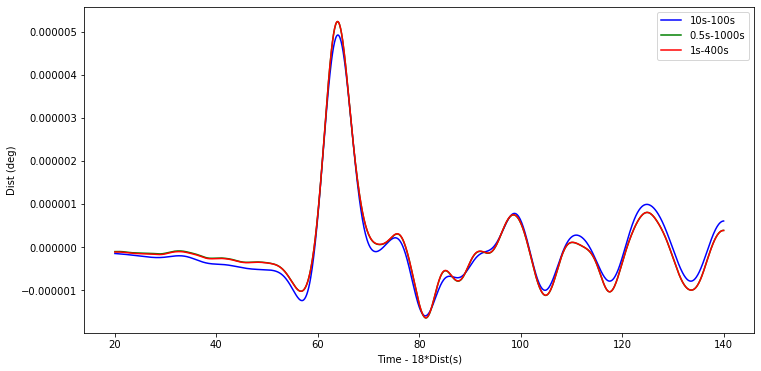

In [50]:
plt.figure(figsize=(12,6))
net_sta="BO.WJM"
asdf_file="/Users/ziyixi/work/Japan_Slab_code/data/asdf_files/compare_data_processing/201105101526A.data.h5"

to_plot_10_100,gcarc=process_single_data_trace_adjust_taper_bandpass(net_sta,asdf_file,10,100)
to_plot_10_100=to_plot_10_100[0]
to_plot_1_400,gcarc=process_single_data_trace_adjust_taper_bandpass(net_sta,asdf_file,1,400)
to_plot_1_400=to_plot_1_400[0]
to_plot_05_1000,gcarc=process_single_data_trace_adjust_taper_bandpass(net_sta,asdf_file,0.5,1000)
to_plot_05_1000=to_plot_05_1000[0]

x=np.linspace(20,to_plot_10_100.stats.endtime-to_plot_10_100.stats.starttime+20,to_plot_10_100.stats.npts)

plt.plot(x,to_plot_10_100.data,color="b",label="10s-100s")
plt.plot(x,to_plot_05_1000.data,color="g",label="0.5s-1000s")
plt.plot(x,to_plot_1_400.data,color="r",label="1s-400s")
plt.legend()
plt.xlabel("Time - 18*Dist(s)")
plt.ylabel("Dist (deg)")

print(to_plot_10_100)